In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas
from pandas import DataFrame
from datetime import datetime

tf.set_random_seed(777)  # reproducibility


def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)



# train Parameters
seq_length = 25
data_dim = 385
hidden_dim = 20
output_dim = 385
predict_day = 1
learning_rate = 0.01
iterations = 500
LSTM_stack = 1



C:\Users\dsba\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from numpy import genfromtxt
from sklearn.preprocessing import StandardScaler, scale
import sklearn
import csv
#with open("Total_index.csv", newline='') as data:
data=genfromtxt('Total_index.csv', delimiter=',')
data=data[1:,1:]
df=DataFrame(data)
df.shape

(3230, 385)

In [3]:
# Convert pandas dataframe to numpy array
dataset_temp = df.as_matrix()

dataset = MinMaxScaler(dataset_temp)

C:\Users\dsba\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [4]:
# build a dataset
dataX = []
dataY = []
dataY_temp = []
for i in range(0, len(dataset) - seq_length-predict_day+1):
    _x = dataset[i:i + seq_length]
    _y = dataset[i + predict_day:i + seq_length+predict_day]
    #print(i + seq_length+predict_day)
    dataX.append(_x)
    dataY.append(_y)
    

trainX = np.array(dataX)
trainY= np.array(dataY)

In [5]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim], name='intput_X')
Y = tf.placeholder(tf.float32, [None, seq_length, data_dim], name='intput_Y')

# build a LSTM network
def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(hidden_dim, state_is_tuple=True) 
    return cell

multi_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(LSTM_stack)], state_is_tuple=True)


outputs_rnn, _states=tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)


In [6]:
_states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 20) dtype=float32>),)

In [7]:
X_for_fc = tf.reshape(outputs_rnn, [-1, hidden_dim])
Y_pred_temp = tf.contrib.layers.fully_connected(X_for_fc, output_dim, activation_fn=None)  
# reshape out for sequence_loss
Y_pred = tf.reshape(Y_pred_temp, [-1, seq_length,output_dim])

In [8]:
Y_pred.shape

TensorShape([Dimension(None), Dimension(25), Dimension(385)])

In [9]:
# cost/loss
mean_loss = tf.reduce_mean(tf.square(Y_pred - Y), name='losses_mean')  # mean of the squares
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mean_loss)

trainY_label=trainY[:,:, :]


In [10]:
len(trainY_label)

3205

In [11]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# Tensorboard
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter("./tensorflowlog", sess.graph)

losslist = [];

# Training step
for i in range(iterations):

    _, step_loss = sess.run([optimizer, mean_loss], 
                                    feed_dict={X: trainX, 
                                               Y: trainY_label})
    losslist = np.append(losslist, step_loss)
    




In [37]:
k=sess.run([Y_pred] ,  feed_dict={X: trainX[0].reshape([1,25,385]), Y: trainY_label[0].reshape([1,25,385])})

In [38]:
k2=k[0][0][0]# 

In [32]:
type(k2)

numpy.ndarray

In [39]:
for i in range(1,3205):
    k=sess.run([Y_pred] ,  feed_dict={X: trainX[i].reshape([1,25,385]), Y: trainY_label[i].reshape([1,25,385])})
    k2=np.vstack((k2,k[0][0][0]))

IndexError: index 3205 is out of bounds for axis 0 with size 3205

In [40]:
k2.shape# 25일치 대입해서 얻은 마지막날 26일째에 대한 예측치, 26~3230일 예측치.

(3205, 385)

In [48]:
y1=list(range(26,3231))
y=np.array(y1)

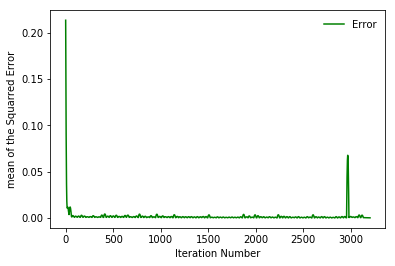

In [41]:
# Plot losss
plt.figure(1)
plt.plot(losslist2, color="green", label="Error");
plt.xlabel("Iteration Number")
plt.ylabel("mean of the Squarred Error")
plt.legend(loc='upper right', frameon=False)

plt.show()

# representation vector 생성

# t-sne 

In [90]:
%matplotlib inline

from sklearn import (datasets,random_projection)
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import Isomap


def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(100,100))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] // 500),
                 fontdict={'weight': 'light', 'size': 70})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(3205):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            #imagebox = offsetbox.AnnotationBbox(
             #   offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
              #  X[i])
            #ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    
    if title is not None:
        plt.title(title)
   

In [89]:
20//15

1

In [85]:
plt.cm.Set1(2)

(0.30196078431372547, 0.6862745098039216, 0.2901960784313726, 1.0)

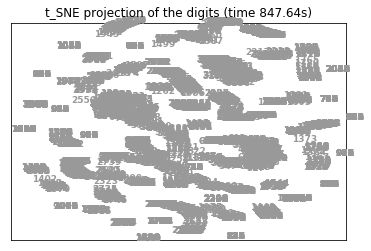

In [56]:
import numpy as np


X=k2
def neg_distance(X):
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return -D


def softmax(X):
    e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))

    np.fill_diagonal(e_x, 0.)

    e_x = e_x + 1e-8

    return e_x / e_x.sum(axis=1).reshape([-1, 1])


def calc_prob_matrix(distances, sigmas=None):
    if sigmas is not None:
        two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
        return softmax(distances / two_sig_sq)
    else:
        return softmax(distances)


def _perplexity(prob_matrix):
    entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
    perplexity = 2 ** entropy
    return perplexity


def perplexity(distances, sigmas):
    return _perplexity(calc_prob_matrix(distances, sigmas))



def binary_search(fn, target, tol=1e-10, max_iter=10000,
                  lower=1e-20, upper=1000.):
    for i in range(max_iter):
        guess = (lower + upper) / 2.
        val = fn(guess)
        if val > target:
            upper = guess
        else:
            lower = guess
        if np.abs(val - target) <= tol:
            break
    return guess


def find_optimal_sigmas(distances, target_perplexity):
    sigmas = []
    # For each row of the matrix (each point in our dataset)
    for i in range(distances.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        fn = lambda sigma: \
            perplexity(distances[i:i+1, :], np.array(sigma))
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)


def p_conditional_to_joint(P):
    return (P + P.T) / (2. * P.shape[0])

def p_joint(X, target_perplexity):
    distances = neg_distance(X)
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    p_conditional = calc_prob_matrix(distances, sigmas)
    P = p_conditional_to_joint(p_conditional)
    return P

def q_joint(Y):
    inv_distances = neg_distance(Y)
    distances = np.power(1. - inv_distances, -1)
    np.fill_diagonal(distances, 0.)
    return distances / np.sum(distances), distances


def tsne_grad(P, Q, Y, distances):
    pq_diff = P - Q
    pq_expanded = np.expand_dims(pq_diff, 2)

    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    distances_expanded = np.expand_dims(distances, 2)
    y_diffs_wt = y_diffs * distances_expanded

    # Multiply then sum over j's
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
    return grad



def t_SNE(X, num_component, num_iters = 500, learning_rate = 10., momentum = .9):

    Y = np.random.normal(0., 0.0001,[X.shape[0], num_component])
    P = p_joint(X, 20)

    # Initialise past values (used for momentum)
    if momentum:
        Y_m2 = Y
        Y_m1 = Y

    # Start gradient descent loop
    for i in range(num_iters):

        # Get Q and distances
        Q, distances = q_joint(Y)

        # Cal gradients
        grads = tsne_grad(P, Q, Y, distances)

        # Update Y
        Y = Y - learning_rate * grads
        if momentum:
            Y += momentum * (Y_m1 - Y_m2)
            # Update previous Y's for momentum
            Y_m2 = Y_m1
            Y_m1 = Y

    return Y

embedding = t_SNE(X = X, num_component = 2)

plot_embedding(embedding,"t_SNE projection of the digits (time %.2fs)" %(time() - t0))

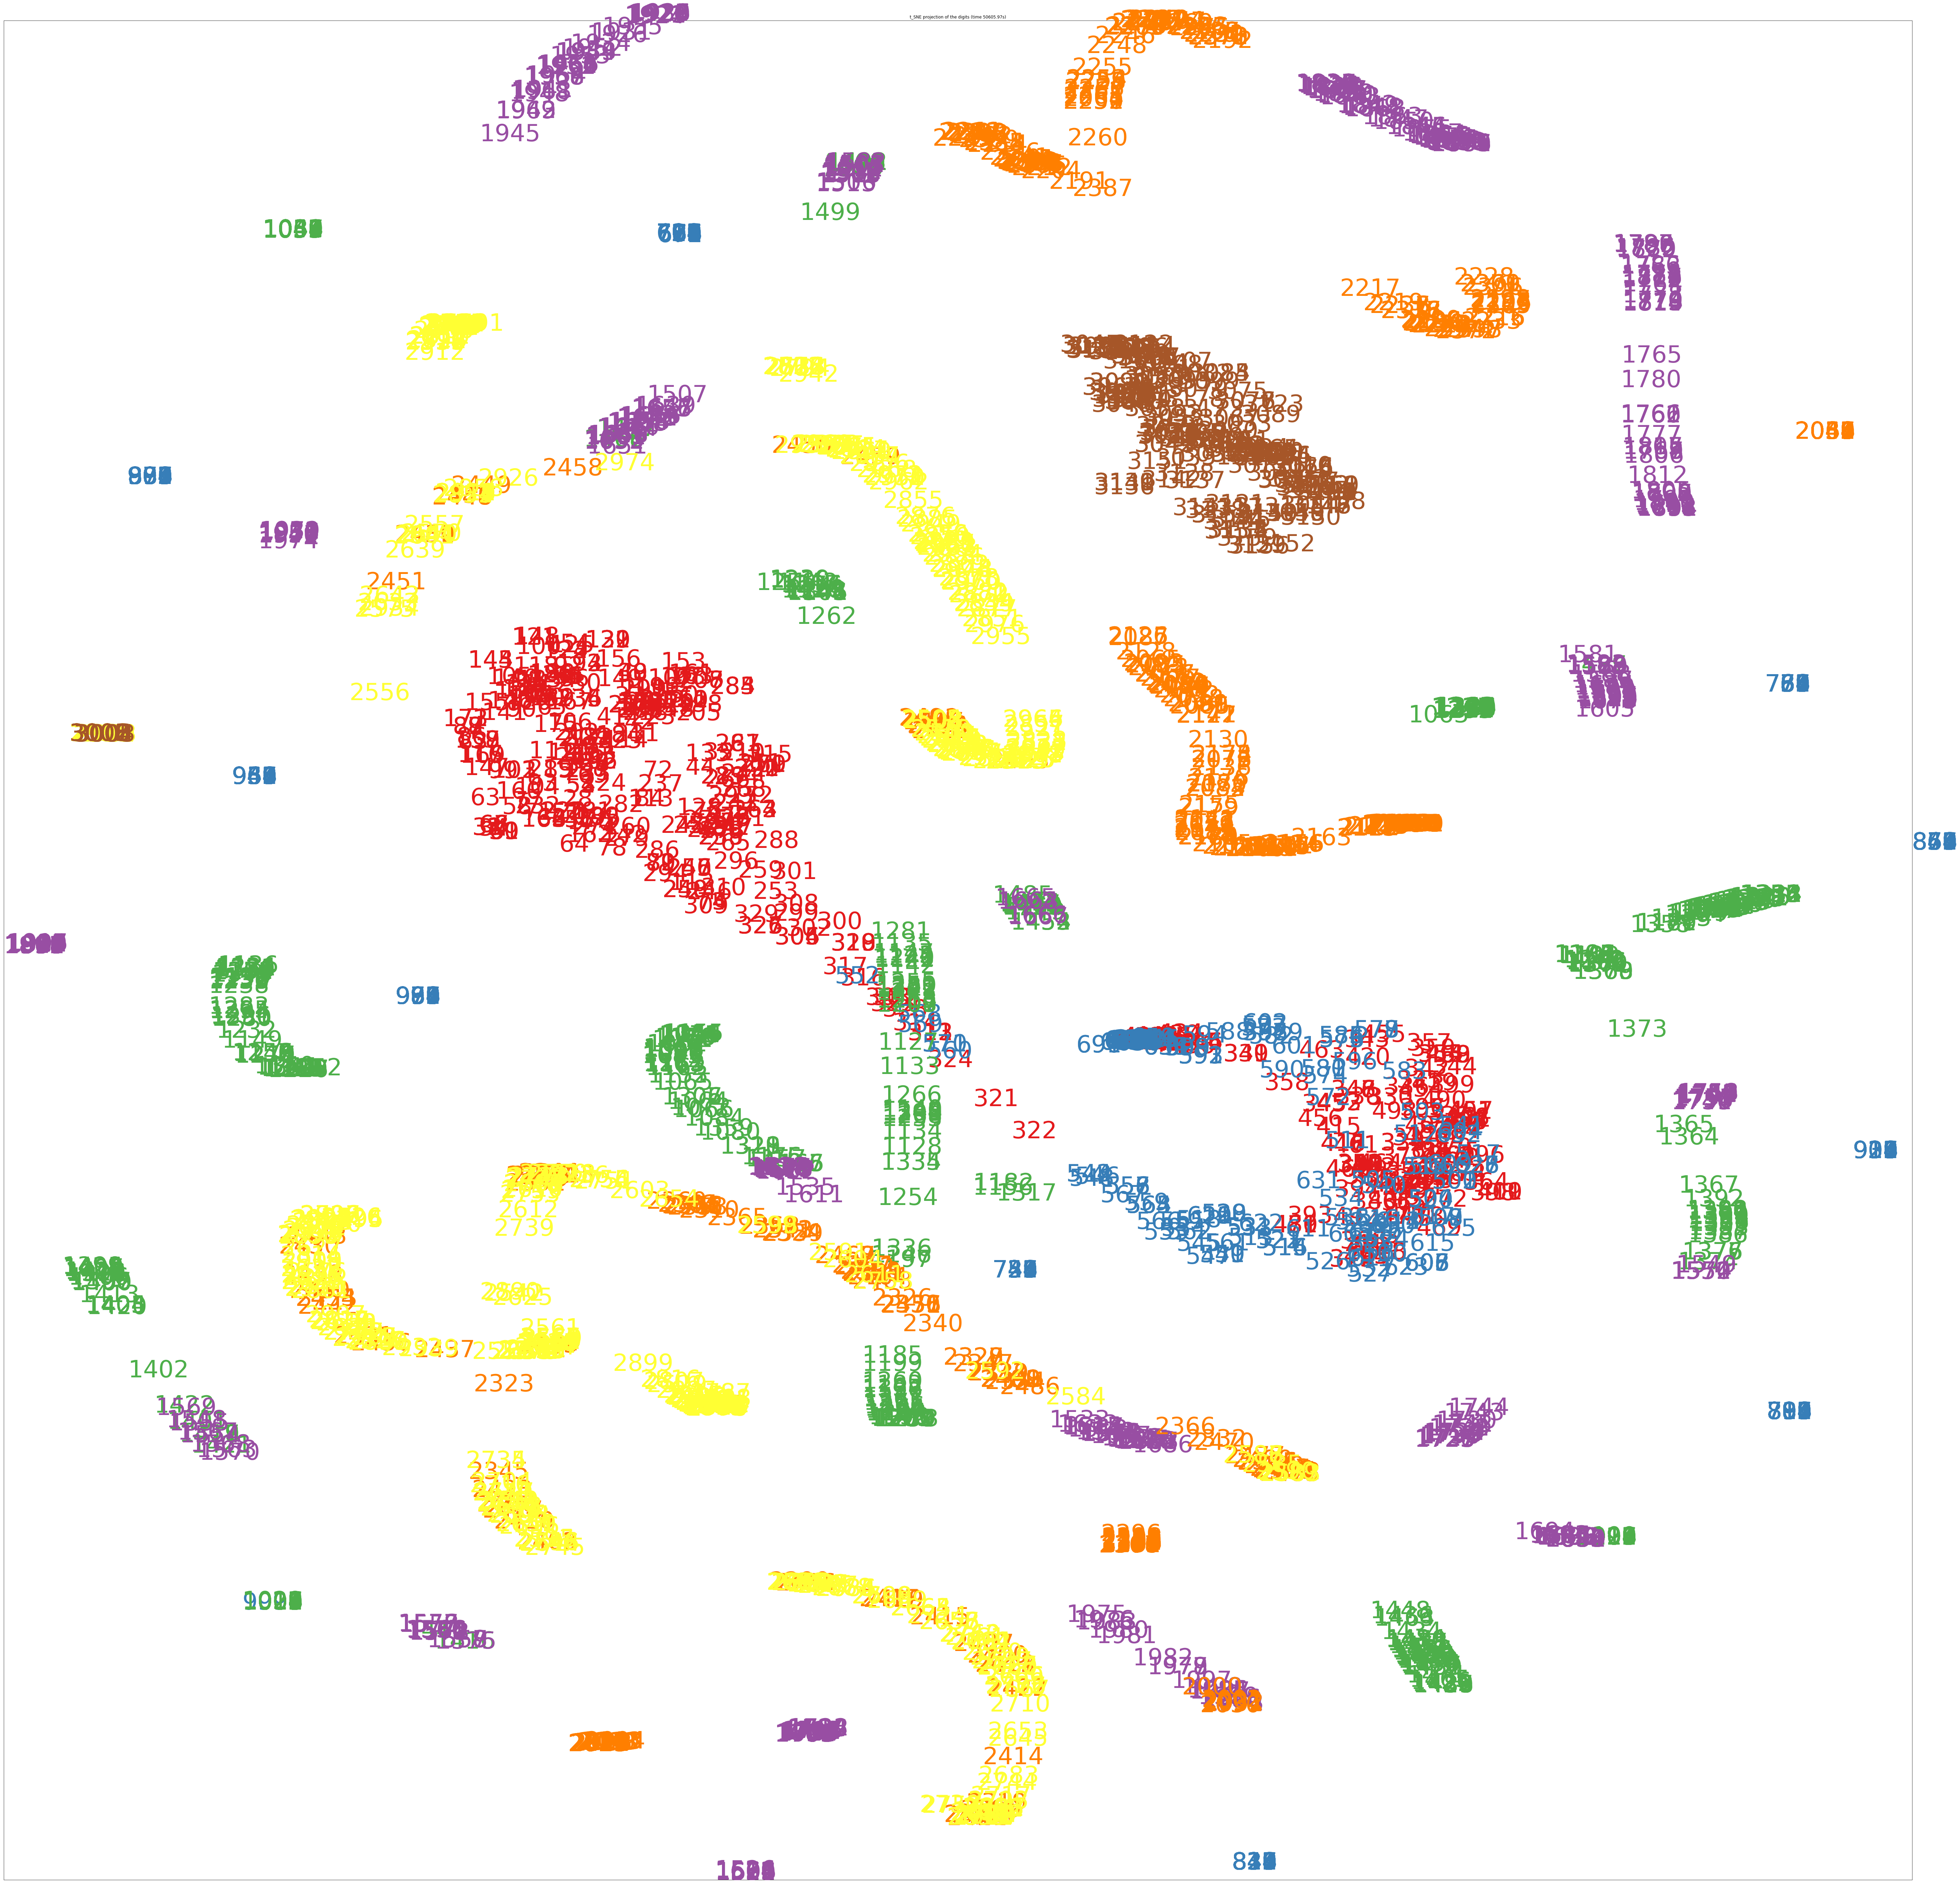

In [91]:
plot_embedding(embedding,"t_SNE projection of the digits (time %.2fs)" %(time() - t0))

텐서로 그려보기 나중에 밑에

In [13]:
## Importing required Libraries
import os
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
## Get working directory
PATH = os.getcwd()

## Path to save the embedding and checkpoints generated
LOG_DIR = PATH + '/project-tensorboard/log-1/'

In [ ]:
## Load data
df = pd.read_csv("scaled_data.csv",index_col =0)
## Load the metadata file. Metadata consists your labels. This is optional. Metadata helps us visualize(color) different clusters that form t-SNE
metadata = os.path.join(LOG_DIR, 'df_labels.tsv')
# Generating PCA and 
pca = PCA(n_components=50,
         random_state = 123,
         svd_solver = 'auto'
         )
df_pca = pd.DataFrame(pca.fit_transform(df))
df_pca = df_pca.values

In [ ]:
tf_data = tf.Variable(df_pca)
## Running TensorFlow Session
with tf.Session() as sess:
    saver = tf.train.Saver([tf_data])
    sess.run(tf_data.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'tf_data.ckpt'))
    config = projector.ProjectorConfig()
# One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = tf_data.name
    # Link this tensor to its metadata(Labels) file
    embedding.metadata_path = metadata
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)